# Aperture, Convolution and Calibration

In [1]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using Device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using Device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


##### Importing modules (including written scripts)

In [1]:
import os
import sys

import re
import pickle
from tqdm import tqdm

import numpy as np
import ccdproc as ccdp
import pandas as pd
from scipy.interpolate import UnivariateSpline
from astropy.convolution import Moffat2DKernel
from adjustText import adjust_text
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib tk
import matplotlib.ticker as mtick
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

import imgprocesslib.imageprocess as ip
from imgprocesslib import homedir, ddir
import imgprocesslib.calibration as clb
from imgprocesslib.calibration import get_hist_info, lim_mag
from astropy.stats import mad_std as mad
import multiprocessing as mp

#from IPython.display import clear_output as clears

In [2]:
def keyfunc(filename):
    return int(re.compile("\D").sub("", filename))

##### Directories

In [3]:
jades_files_path = ccdp.ImageFileCollection(ddir).files_filtered(include_path=True)[:-1]
jade_path = ddir + "/jwst_jades-gs_dr1_f335m_30mas_microJy.fits"

##### Star Coordinates and setting Detection Threshold

In [4]:
StarLims = np.array((#[np.float64([10630, 10660]), np.float64([12410, 12430])],
                     #[np.float64([17480, 17523]), np.float64([8350, 8370])],
                     #[np.float64([15861, 15863]), np.float64([11461, 11563])],
                     #[np.float64([13185, 13249]), np.float64([9189, 9261])],
                     #[np.float64([16750, 16780]), np.float64([7280, 7300])], #<<<
                     [np.float64([14480, 14530]), np.float64([7130, 7150])],
                    ), dtype=float)

In [ ]:
#d_array = [5000, 5000, 5000, 5000, 6000, 5000, 500, 5000, 1150, 5000, 
#           5000, 400, 1000, 4000, 4000, 4000, 5000, 5000, 5000] #13185 - 13249, 9189 - 9261

#d_array = [5000, 5000, 5000, 5000, 5000, 5000, 500, 5000, 5000, 5000, 
#           5000, 5000, 5000, 3000, 3000, 5000, 5000, 5000, 5000] #16750 - 16780, 7280 - 7300

d_array = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 
           1000, 200, 5000, 500, 500, 1000, 5000, 1000, 5000] #14480 - 14520, 7130 - 7150      10, 13, 14, 15, 17

### Debug to check Extracted Objects
Check for optimal Threshold

In [ ]:
i = 12
#for i in range(len(d_array)):
params = {'dpi': 100,
            #'objxlim': StarLims[:, 0],
            #'objylim': StarLims[:, 1],
            #'xlim':(5500, 19500), 
            #'ylim':(2750, 18000),
            'detThesh': d_array[i],
            #'block': False,
            'vmin': 35,
            'vmax': 97,
            #'cmap': cmaps.oranges_dark,
            #'checkBkg': True
            }

ef = ip.extract_objects_flux(jades_files_path[i], bw=256, fw=4, **params)
ef.plot_detected_sources(size=125)
plt.show()
ef.objs['x']+ef.zero_x, ef.objs['y']+ef.zero_y, ef.objs['flux']

: 

### Curve of Growth

In [ ]:
#d_array = np.array([5000, 5000, 5000, 5000, 6000, 5000, 500, 5000, 1150, 5000, 5000, 400, 1000, 4000, 4000, 4000, 5000, 5000, 5000])
#d_array = [5000, 5000, 5000, 5000, 5000, 5000, 500, 5000, 5000, 5000, 5000, 5000, 5000, 3000, 3000, 5000, 5000, 5000, 5000]

``` os.path.abspath(os.curdir) ```

• Get data and export to file

In [ ]:
AptR = np.arange(1, 125, 0.5)

In [ ]:
params = {#'dpi': 500,
         'objxlim': StarLims[:, 0],
         'objylim': StarLims[:, 1],
         'detThesh': d_array,
          #'xlim':(5500, 19500), 
          #'ylim':(2750, 18000),
          #'block': False,
          #'vmin': 25,
          #'vmax': 98,
          #'cmap': cmaps.oranges_dark,
          #'checkBkg': True
         }

c_params = {
    'detThesh': d_array
}

ResData = ip.multiAperFileFlux(jades_files_path[:-1], AptR, change_params=c_params, **params)

Processing: 18 files
  0%|          | 0/18 [00:04<?, ?it/s]


KeyboardInterrupt: 

```
AptR = np.arange(1, 30, 0.5)
ResData = []

with tqdm(total=len(jades_files_path), file=sys.stdout) as pbar:
    for fileNo, (d, datafile) in enumerate(zip(d_array, jades_files_path)):
        params = {#'dpi': 500,
                'objxlim': StarLims[:, 0],
                'objylim': StarLims[:, 1],
                #'xlim':(5500, 19500), 
                #'ylim':(2750, 18000),
                'detThesh': d,
                #'block': False,
                #'vmin': 25,
                #'vmax': 98,
                #'cmap': cmaps.oranges_dark,
                #'checkBkg': True
                }

        ResData += [{
            'file': os.path.basename(datafile),
            'results': [ip.multiAptFindFlux(datafile, AptR, **params)]
        }]

        pbar.set_description('Processed: %d' %(1 + fileNo))
        pbar.update(1)
```

##### Import data from output file

In [ ]:
with open('Output/14525_7131_apers(1.0-124.5).pkl', 'rb') as file:
    ResData = pickle.load(file)

In [ ]:
stardata = []
#stardataerr = []
for fileRes in ResData:
    onestar = []
    #onestarerr =[]
    for res in fileRes['results']:
        onestar += [res['flux'][0]]
        #onestarerr += [res['fluxerr'][0]]
    stardata += [onestar]
    #stardataerr += [onestarerr]

starfile = [] #np.zeros(len(ResData))
for k in ResData:
    starfile.append(k['file'].rsplit('_', 2)[0].rsplit('_', 1)[1])
    #print(k['file'].rsplit('_', 2)[0].rsplit('_', 1)[1])

len(stardata)

19

In [ ]:
# Fluxes at the highest aperture set (349.5) for each file.
for i in range(len(stardata)):
    print(starfile[i], ":", stardata[i][-1])

f090w : 19.577089580983053
f115w : 30.34060895758371
f150w : 30.28505658920809
f182m : 25.938959170007113
f200w : 26.877562716589303
f210m : 25.63799445932417
f277w : 15.753904842136413
f335m : 13.978428009582952
f356w : 13.753252764919287
f410m : 13.305419217589366
f430m : 11.715043945669558
f435w : 0.285437092783783
f444w : 11.108316812058868
f460m : 9.67480220877869
f480m : 8.811749421445164
f606w : 1.6325468783438581
f775w : 9.84146623847054
f814w : 11.998271673112331
f850lp : 19.445188992656497


```
colours = ['r','#93785b', '#4f6032', '#42b8fb', '#3f1920', '#c909a2', 
           '#f4a669', '#d55c69', '#8ca997', '#fec094', '#c6d3e7', '#b3de4d',
           '#753011', '#dfbf11', '#c9a99c', '#7b7957', '#1d531b', '#aea8b9',
           '#5b565a']

plt.figure(dpi=500)
keylist = []

#for key, ax in keylist, ax.flatten() 
for data, name, c in zip(stardata, starfile, colours):
    plt.scatter(AptR, (data/data[-1])*100, s=1, alpha=0.8, c=c)
    if re.compile(r'm').findall(name):
        plt.plot(AptR, (data/data[-1])*100, label='{0}'.format(name), linestyle='--', linewidth=1, alpha=0.9, c=c)
    else:
        plt.plot(AptR, (data/data[-1])*100, label='{0}'.format(name), linewidth=1, alpha=0.9, c=c)

plt.title("Star ({0}, {1})".format(int(ResData[0]['results'][0]['x']), int(ResData[0]['results'][0]['y'])))
plt.xlabel('Aperture Radius')
plt.ylabel('Relative Enclosed Flux (%)')
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(5))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.legend(ncol = 3, prop = {'size' : 9}, handlelength=1, columnspacing=0.8)
plt.show()
```

In [ ]:
filters_list  = [{'Telescope': 'NIRCam Short Wavelength',
                  'filters': ['090w', '115w', '150w', '182m', '200w', '210m'],
                  'colours': ['#B7AAEE', '#AF47FF', '#5C55B3', '#99CCFF', '#00A8E0', '#0101DF']},
                 {'Telescope': 'NIRCam Long Wavelength',
                  'filters': ['277w', '335m', '356w', '410m', '430m', '444w', '460m', '480m'],
                  'colours': ['#256E37', '#B58653', '#C8D96F', '#A84900', '#51C083', '#6DB41D', '#89931E', '#0B412B']},
                 {'Telescope': 'HST ACS', 
                  'filters': ['435w', '606w', '775w', '814w', '850lp'],
                  'colours': ['#660000', '#DD0000', '#DB2E6B', 'orange', '#E0D100']},
                ]
#9EA923
#'#EEBA0B' '#A63C06' '#339E71' #CF2626 #DC602E 

In [ ]:
def subplots_centered(nrows, ncols, figsize, nfigs, dpi=100, sharex=False, sharey=False):
    """
    Modification of matplotlib plt.subplots(),
    useful when some subplots are empty.
    
    It returns a grid where the plots
    in the **last** row are centered.
    
    Inputs
    ------
        nrows, ncols, figsize: same as plt.subplots()
        nfigs: real number of figures
    """
    assert nfigs < nrows * ncols, "No empty subplots, use normal plt.subplots() instead"
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    axs = []
    
    m = nfigs % ncols
    m = range(1, ncols+1)[-m]  # subdivision of columns
    gs = gridspec.GridSpec(nrows, m*ncols)

    for i in range(0, nfigs):
        row = i // ncols
        col = i % ncols

        if row == nrows-1: # center only last row
            off = int(m * (ncols - nfigs % ncols) / 2)
        else:
            off = 0

        ax = plt.subplot(gs[row, m*col + off : m*(col+1) + off])
        axs.append(ax)
        
    return fig, axs

In [ ]:
AptR[138]

70.0

In [ ]:
pixel = 0.03
AptR *= pixel
AptR

array([0.03 , 0.045, 0.06 , 0.075, 0.09 , 0.105, 0.12 , 0.135, 0.15 ,
       0.165, 0.18 , 0.195, 0.21 , 0.225, 0.24 , 0.255, 0.27 , 0.285,
       0.3  , 0.315, 0.33 , 0.345, 0.36 , 0.375, 0.39 , 0.405, 0.42 ,
       0.435, 0.45 , 0.465, 0.48 , 0.495, 0.51 , 0.525, 0.54 , 0.555,
       0.57 , 0.585, 0.6  , 0.615, 0.63 , 0.645, 0.66 , 0.675, 0.69 ,
       0.705, 0.72 , 0.735, 0.75 , 0.765, 0.78 , 0.795, 0.81 , 0.825,
       0.84 , 0.855, 0.87 , 0.885, 0.9  , 0.915, 0.93 , 0.945, 0.96 ,
       0.975, 0.99 , 1.005, 1.02 , 1.035, 1.05 , 1.065, 1.08 , 1.095,
       1.11 , 1.125, 1.14 , 1.155, 1.17 , 1.185, 1.2  , 1.215, 1.23 ,
       1.245, 1.26 , 1.275, 1.29 , 1.305, 1.32 , 1.335, 1.35 , 1.365,
       1.38 , 1.395, 1.41 , 1.425, 1.44 , 1.455, 1.47 , 1.485, 1.5  ,
       1.515, 1.53 , 1.545, 1.56 , 1.575, 1.59 , 1.605, 1.62 , 1.635,
       1.65 , 1.665, 1.68 , 1.695, 1.71 , 1.725, 1.74 , 1.755, 1.77 ,
       1.785, 1.8  , 1.815, 1.83 , 1.845, 1.86 , 1.875, 1.89 , 1.905,
       1.92 , 1.935,

In [ ]:
#(data/data[-1])*100

In [ ]:
AptR[138]

2.1

In [ ]:
stardata[0][138]

19.662432275079677

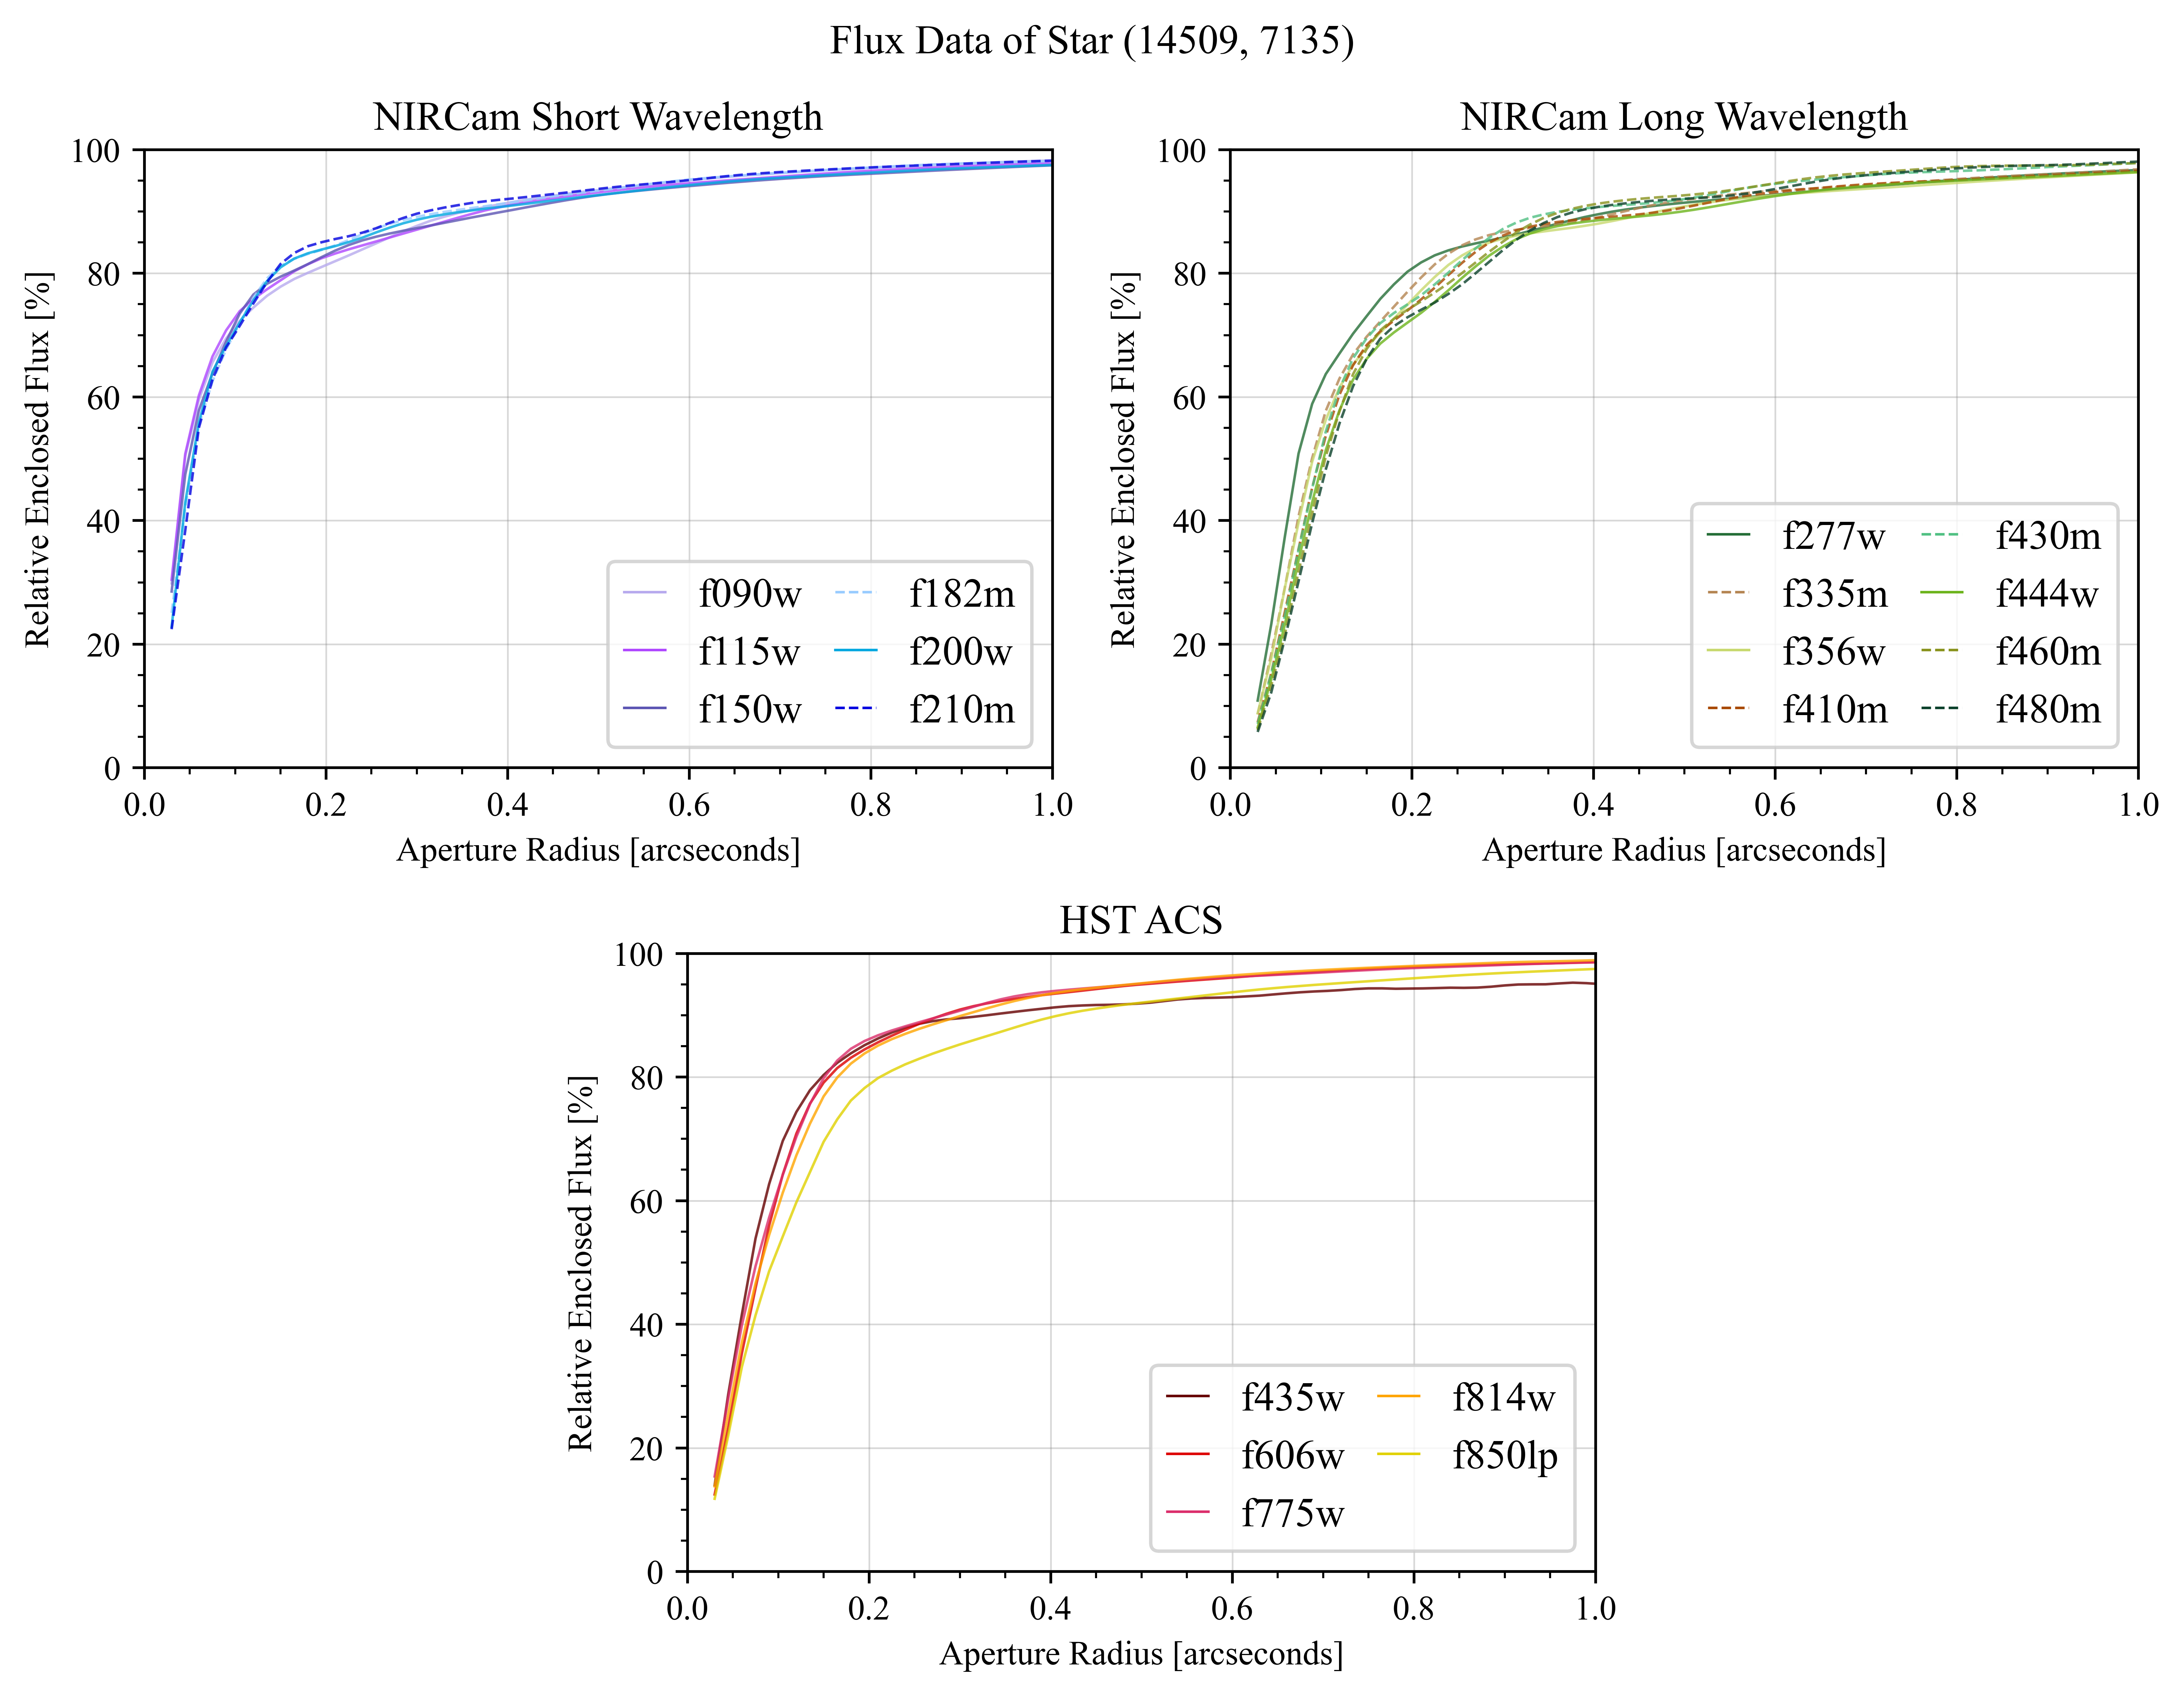

In [ ]:
fig, axes = subplots_centered(nrows=2, ncols=2, figsize=(9,7), nfigs=3, dpi=700, sharex=True, sharey=True)
#plt.tight_layout()

#fig = plt.figure(figsize=(4,9), dpi=500)
#gs = fig.add_gridspec(3) #hspace=2, height_ratios=[2,1]
#axes = gs.subplots(sharex=True, sharey=True)

for i, (ax, list_fil) in enumerate(zip(axes, filters_list)):
    ax.title.set_text('{}'.format(list_fil['Telescope']))

    if i != 0:
        ax.sharex(axes[0])
        ax.sharey(axes[0])
        
    for fil, col in zip(list_fil['filters'], list_fil['colours']):
        for data, name in zip(stardata, starfile):
            if re.compile('{}'.format(fil)).findall(name):
                #ax.scatter(AptR, (data/data[-1])*100, s=0.1, alpha=0.9, c=col)
                #ax.errorbar(AptR, (data/data[-1])*100, xerr=err, ecolor=col, elinewidth=0.01, alpha=0.3, capsize=1, linewidth=0)
                if re.compile(r'm').findall(name):
                    ax.plot(AptR, (data/data[138])*100, label='{0}'.format(name), linestyle='--', linewidth=0.75, alpha=0.8, c=col)
                else:
                    ax.plot(AptR, (data/data[138])*100, label='{0}'.format(name), linewidth=0.75, alpha=0.8, c=col)

    ax.grid(True, color="gray", linewidth="0.5", linestyle = "-", alpha=0.3)
    ax.set_xlabel('Aperture Radius [arcseconds]')
    ax.set_ylabel('Relative Enclosed Flux [%]')
    leg = ax.legend(loc=4, ncol=2, prop={'size' : 12}, handlelength=1, columnspacing=0.8)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)

fig.suptitle("Flux Data of Star ({0}, {1})".format(int(ResData[0]['results'][0]['x'][0]), int(ResData[0]['results'][0]['y'][0])))
#fig.text(0.5, 0., 'Aperture Radius', ha='center')
#fig.text(0., 0.5, r'Relative Enclosed Flux [%]', va='center', rotation='vertical')
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlim(0, 1)
plt.ylim(0, 100)
fig.tight_layout()
plt.show()

___

## Convolution of the data

In [ ]:
d_array = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 
           1000, 200, 5000, 500, 500, 1000, 5000, 1000, 5000]

gammas = [3.1, 3.22, 3.225, 3.325, 3.325, 3.4, 2.665, 2.1, 1.8, 1.5, 1.8, 3.25, 1.4, 1., 3.2, 3.3, 3.3, 2.1]
alphas = [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2]

In [ ]:
_ = d_array.pop(12)

In [ ]:
AptR = np.arange(1, 125, 0.5)

#i = 18
params = {'dpi': 100,
          'objxlim': StarLims[:, 0],
          'objylim': StarLims[:, 1],
          #'xlim':(5500, 19500), 
          #'ylim':(2750, 18000),
          #'detThesh': d_array[i],
          #'block': False,
          #'vmin': 25,
          #'vmax': 98,
          #'cmap': cmaps.oranges_dark,
          #'checkBkg': True
          #'kernel': Moffat2DKernel(gamma=2, alpha=5),
          #'convolve': True,
          #'PLOT': True,
          #'PARALLEL': True,
          #'chunks': 6,
          #'gamma': 2.1,
          #'alpha': 2.2
         }

c_params = {
    'detThesh': d_array,
    'gamma': gammas,
    'alpha': alphas,
}                                                    

data = ip.convolve_moffat(jades_files_path[12], jades_files_path, AptR, Aper_target=int(np.round(0.175/0.03)),
                           #gamma=2.4, alpha=2, 
                           change_params=c_params, **params)


Processing traget file


KeyboardInterrupt: 

In [ ]:
with open('Output/convolved_14509_7135_apers(1.0-124.5).pkl', 'rb') as file:
    data = pickle.load(file)

In [ ]:
target_data = []
for dat in data['target']:
    target_data.append(dat['flux'][0])

In [ ]:
allfile = []
allfilename = []

for file_data in data['convolved']:
    onefile = []
    for dat in file_data['results']:
        onefile.append(dat['flux'][0])

    allfile.append(onefile)
    allfilename.append(file_data['file'].rsplit('_', 2)[0].rsplit('_', 1)[1])

In [ ]:
AptR = np.arange(1, 125, 0.5)
pixel = 0.03
AptR *= pixel
AptR

array([0.03 , 0.045, 0.06 , 0.075, 0.09 , 0.105, 0.12 , 0.135, 0.15 ,
       0.165, 0.18 , 0.195, 0.21 , 0.225, 0.24 , 0.255, 0.27 , 0.285,
       0.3  , 0.315, 0.33 , 0.345, 0.36 , 0.375, 0.39 , 0.405, 0.42 ,
       0.435, 0.45 , 0.465, 0.48 , 0.495, 0.51 , 0.525, 0.54 , 0.555,
       0.57 , 0.585, 0.6  , 0.615, 0.63 , 0.645, 0.66 , 0.675, 0.69 ,
       0.705, 0.72 , 0.735, 0.75 , 0.765, 0.78 , 0.795, 0.81 , 0.825,
       0.84 , 0.855, 0.87 , 0.885, 0.9  , 0.915, 0.93 , 0.945, 0.96 ,
       0.975, 0.99 , 1.005, 1.02 , 1.035, 1.05 , 1.065, 1.08 , 1.095,
       1.11 , 1.125, 1.14 , 1.155, 1.17 , 1.185, 1.2  , 1.215, 1.23 ,
       1.245, 1.26 , 1.275, 1.29 , 1.305, 1.32 , 1.335, 1.35 , 1.365,
       1.38 , 1.395, 1.41 , 1.425, 1.44 , 1.455, 1.47 , 1.485, 1.5  ,
       1.515, 1.53 , 1.545, 1.56 , 1.575, 1.59 , 1.605, 1.62 , 1.635,
       1.65 , 1.665, 1.68 , 1.695, 1.71 , 1.725, 1.74 , 1.755, 1.77 ,
       1.785, 1.8  , 1.815, 1.83 , 1.845, 1.86 , 1.875, 1.89 , 1.905,
       1.92 , 1.935,

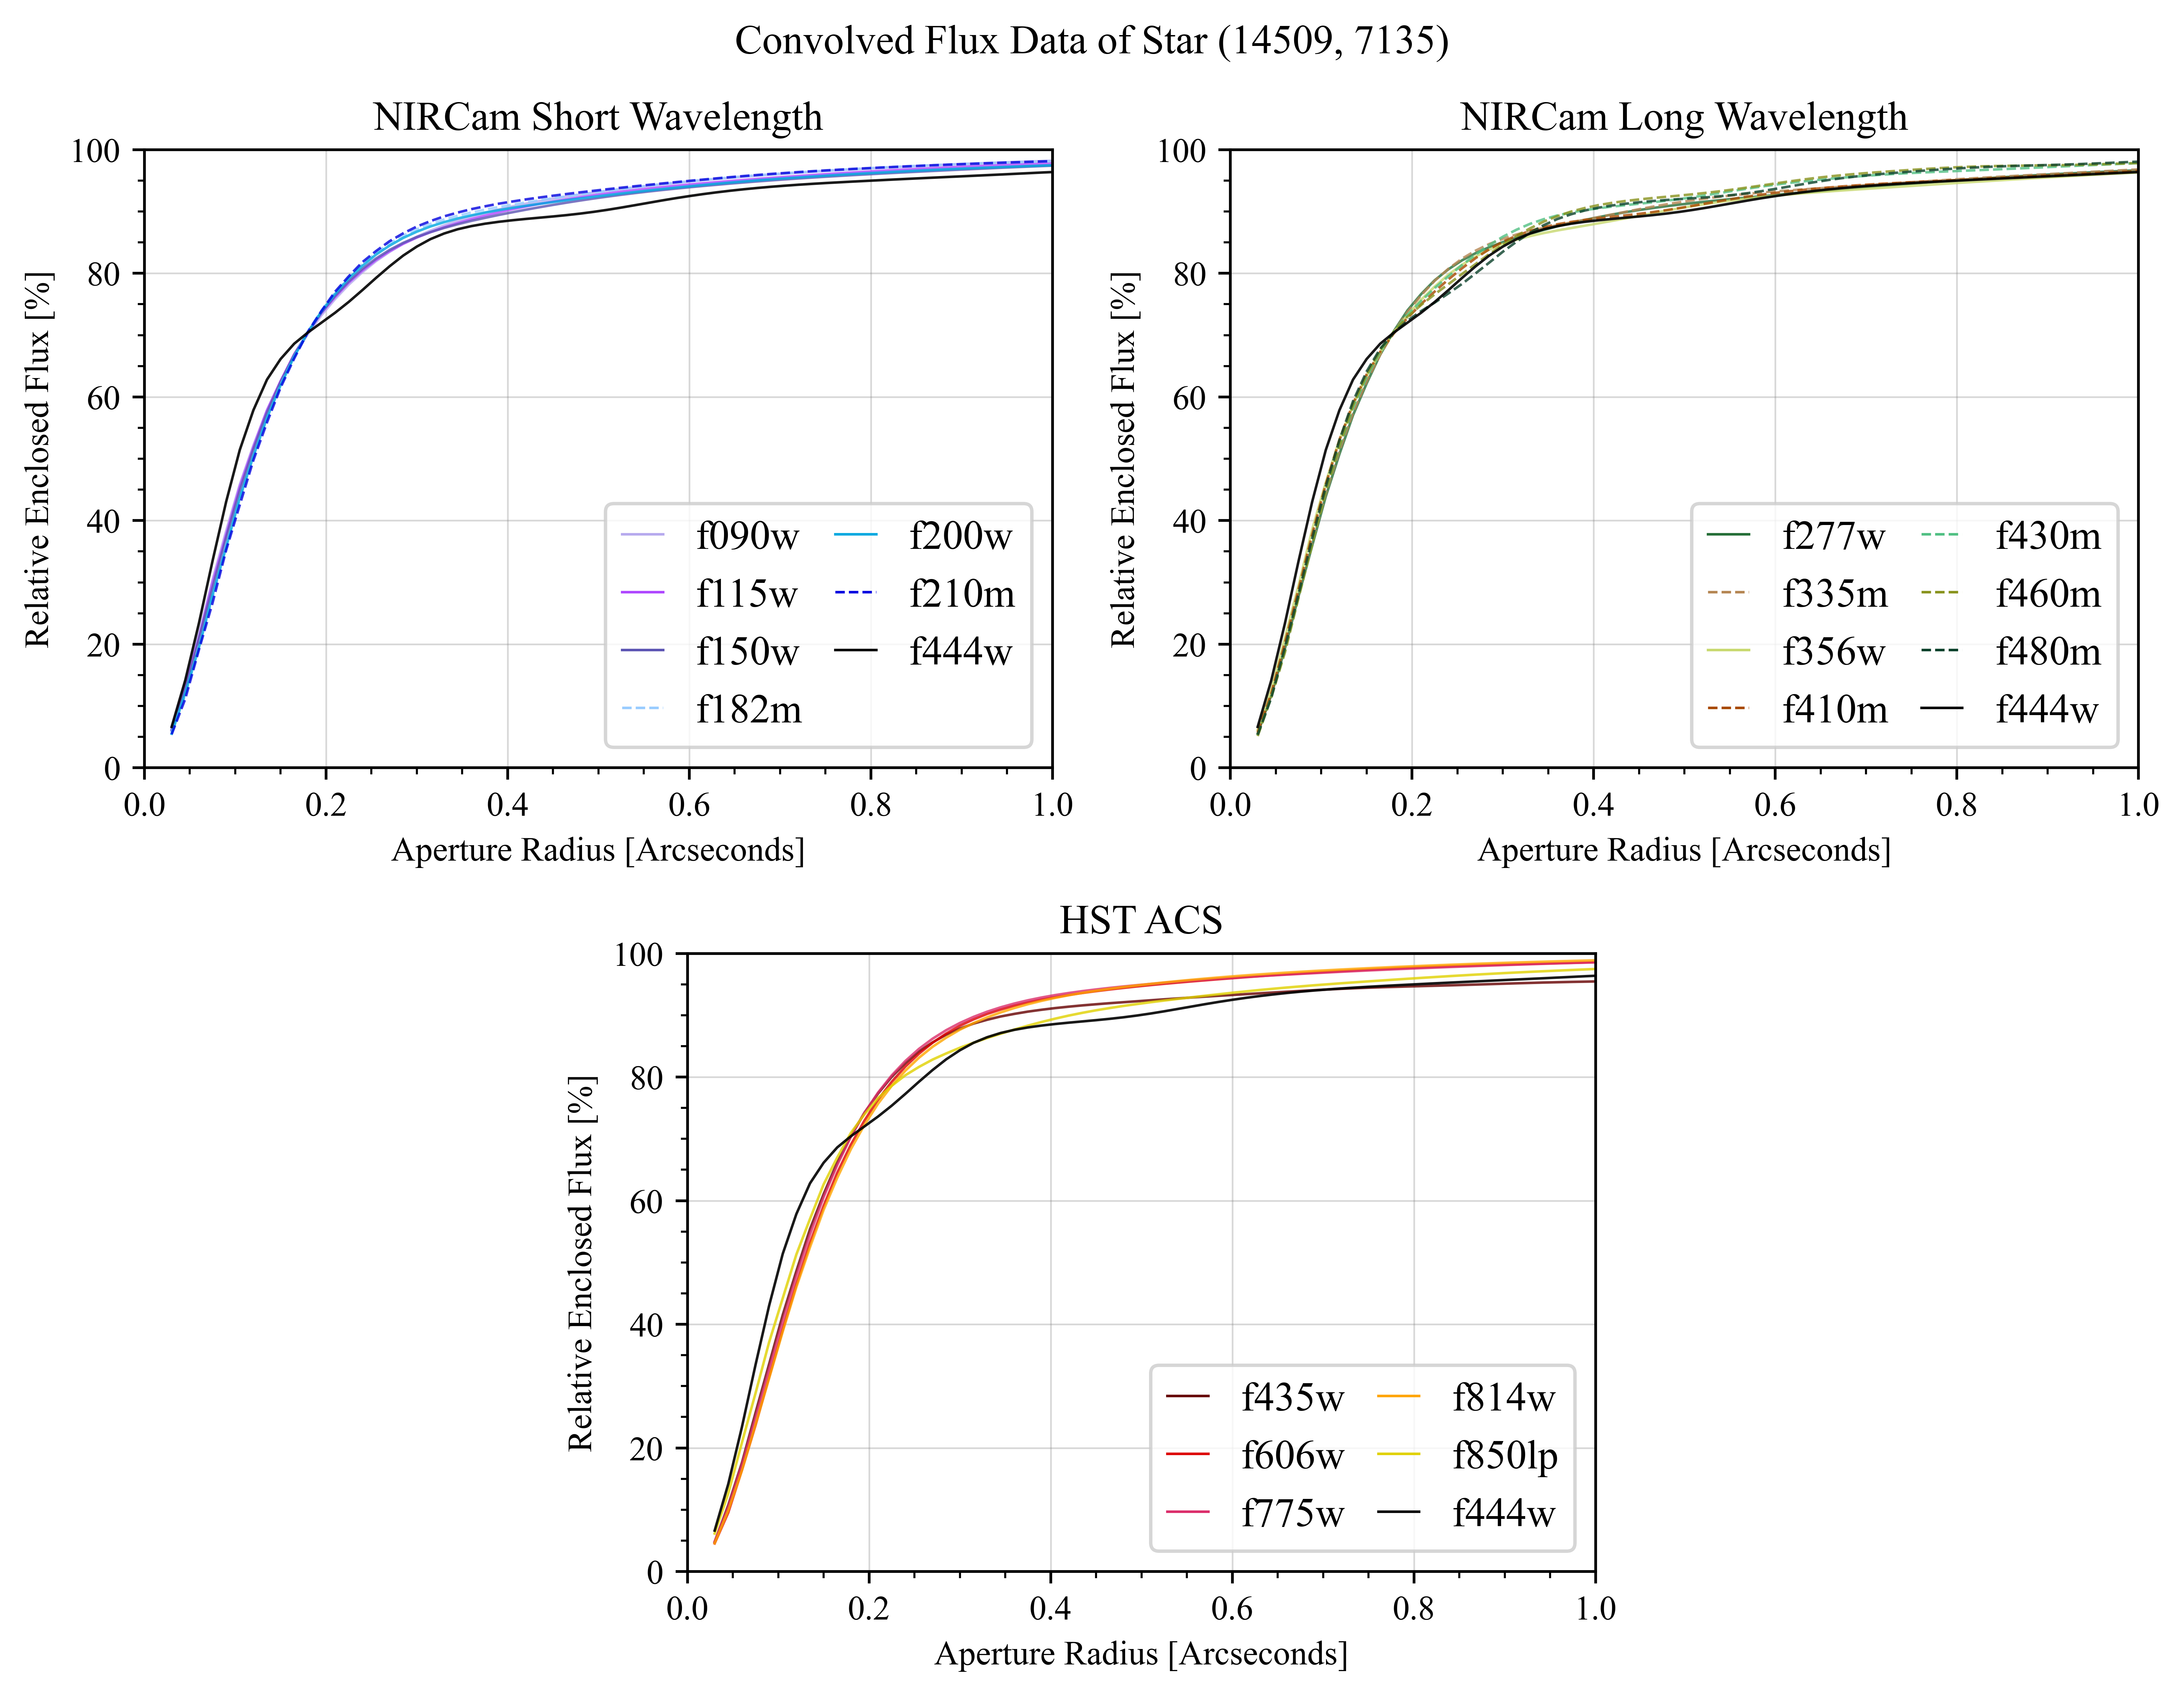

In [ ]:
fig, axes = subplots_centered(nrows=2, ncols=2, figsize=(9,7), nfigs=3, dpi=700, sharex=True, sharey=True)

for i, (ax, list_fil) in enumerate(zip(axes, filters_list)):
    ax.title.set_text('{}'.format(list_fil['Telescope']))

    if i != 0:
        ax.sharex(axes[0])
        ax.sharey(axes[0])
        
    for fil, col in zip(list_fil['filters'], list_fil['colours']):
        for data, name in zip(allfile, allfilename):
            if re.compile('{}'.format(fil)).findall(name):
                #ax.scatter(AptR, (data/data[138])*100, s=0.1, alpha=0.9, c=col)
                #ax.errorbar(AptR, (data/data[138])*100, xerr=err, ecolor=col, elinewidth=0.01, alpha=0.3, capsize=1, linewidth=0)
                if re.compile(r'm').findall(name):
                    ax.plot(AptR, (data/data[138])*100, label='{0}'.format(name), linestyle='--', linewidth=0.75, alpha=0.8, c=col)
                else:
                    ax.plot(AptR, (data/data[138])*100, label='{0}'.format(name), linewidth=0.75, alpha=0.8, c=col)
    
    ax.plot(AptR, (target_data/target_data[138])*100, label='{0}'.format('f444w'), linestyle='-', linewidth=0.75, alpha=0.9, c='black')
               
    ax.grid(True, color="gray", linewidth="0.5", linestyle = "-", alpha=0.3)
    ax.set_xlabel('Aperture Radius [Arcseconds]')
    ax.set_ylabel('Relative Enclosed Flux [%]')
    leg = ax.legend(loc=4, ncol=2, prop={'size' : 12}, handlelength=1, columnspacing=0.8)
    for lh in leg.legend_handles: 
        lh.set_alpha(1)
    
fig.suptitle("Convolved Flux Data of Star ({0}, {1})".format(int(ResData[0]['results'][0]['x'][0]), int(ResData[0]['results'][0]['y'][0])))
#fig.text(0.5, 0., 'Aperture Radius', ha='center')
#fig.text(0., 0.5, r'Relative Enclosed Flux [%]', va='center', rotation='vertical')
plt.gca().xaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.gca().yaxis.set_minor_locator(mtick.AutoMinorLocator(4))
plt.xlim(0, 1)
plt.ylim(0, 100)
fig.tight_layout()
plt.show()

___

## Calibration (Sigma limit)

#### Testing code snippet

In [ ]:
from astropy.io import fits

data = fits.getdata(jades_files_path[0])
data = data.byteswap().newbyteorder()
data.shape

(21001, 25001)

In [ ]:
inc = int(11.67 + 2)
x_size = data.shape[1]//inc
y_size = data.shape[0]//inc

x_list = np.zeros((x_size*y_size))
y_list = np.zeros((x_size*y_size))

#### ----------------------------------
run_exe.py

In [1]:
import os
import sys

import re
import pickle
from tqdm import tqdm

import numpy as np
import ccdproc as ccdp
import pandas as pd
from astropy.convolution import Moffat2DKernel
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#%matplotlib tk
import matplotlib.ticker as mtick
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'

import imgprocesslib.imageprocess as ip
from imgprocesslib import homedir, ddir
#import imgprocesslib.calibration as clb
import imgprocesslib.makecatologuecpu as mkcat
#from imgprocesslib.calibration import get_hist_info, lim_mag
from astropy.stats import mad_std as mad

#from IPython.display import clear_output as clears

In [2]:
jades_files_path = ccdp.ImageFileCollection(ddir).files_filtered(include_path=True)
jades_files_path[8]

'c:\\Users\\blybe\\OneDrive - University of Edinburgh\\MPhys Project/Jades_files/jwst_jades-gs_dr1_f356w_30mas_microJy.fits'

In [15]:
gammas = [3.1, 3.22, 3.225, 3.325, 3.325, 3.4, 2.665, 2.1, 1.8, 1.5, 1.8, 3.25, 1.4, 1., 3.2, 3.3, 3.3, 2.1]
alphas = [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2]

print(gammas[8], alphas[8])

1.8 2.2


: 

In [3]:
aper_size = 5.83
i = 8

gammas = [3.1, 3.22, 3.225, 3.325, 3.325, 3.4, 2.665, 2.1, 1.8, 1.5, 1.8, 3.25, 1.4, 1., 3.2, 3.3, 3.3, 2.1]
alphas = [2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.3, 2.3, 2.3, 2.2]

params = {#'dpi': 200,
          #'bins': 50,
          'detThesh': 2,
          #'step_size': 1,
          'tolerance': 1e-1,
          'kernel': Moffat2DKernel(gamma=gammas[i], alpha=alphas[i]),
          'SAVE': True,
          'CONVOLVE': True,
          'filetype': ('txt', 'pkl'),
          }

c_params = {
    'gamma': gammas,
    'alpha': alphas,
}

mkcat.MakeCatologue(jades_files_path[i], jades_files_path, aper_size, change_kwargs=c_params, **params)

Processing Detection Image


#### ----------------------------------

In [3]:
# Load the pickle file
data = pd.DataFrame(pd.read_pickle(homedir + 'Output/photometric_convolved_catalogue_f356w_apers_5.83_tol_0.1_detThresh_2.pkl'))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
data.keys()

Index(['id', 'RA', 'Dec', 'x-position', 'y-position', 'f090w', 'f115w',
       'f150w', 'f182m', 'f200w', 'f210m', 'f277w', 'f335m', 'f356w', 'f410m',
       'f430m', 'f435w', 'f444w', 'f460m', 'f480m', 'f606w', 'f775w', 'f814w',
       'f850lp'],
      dtype='object')

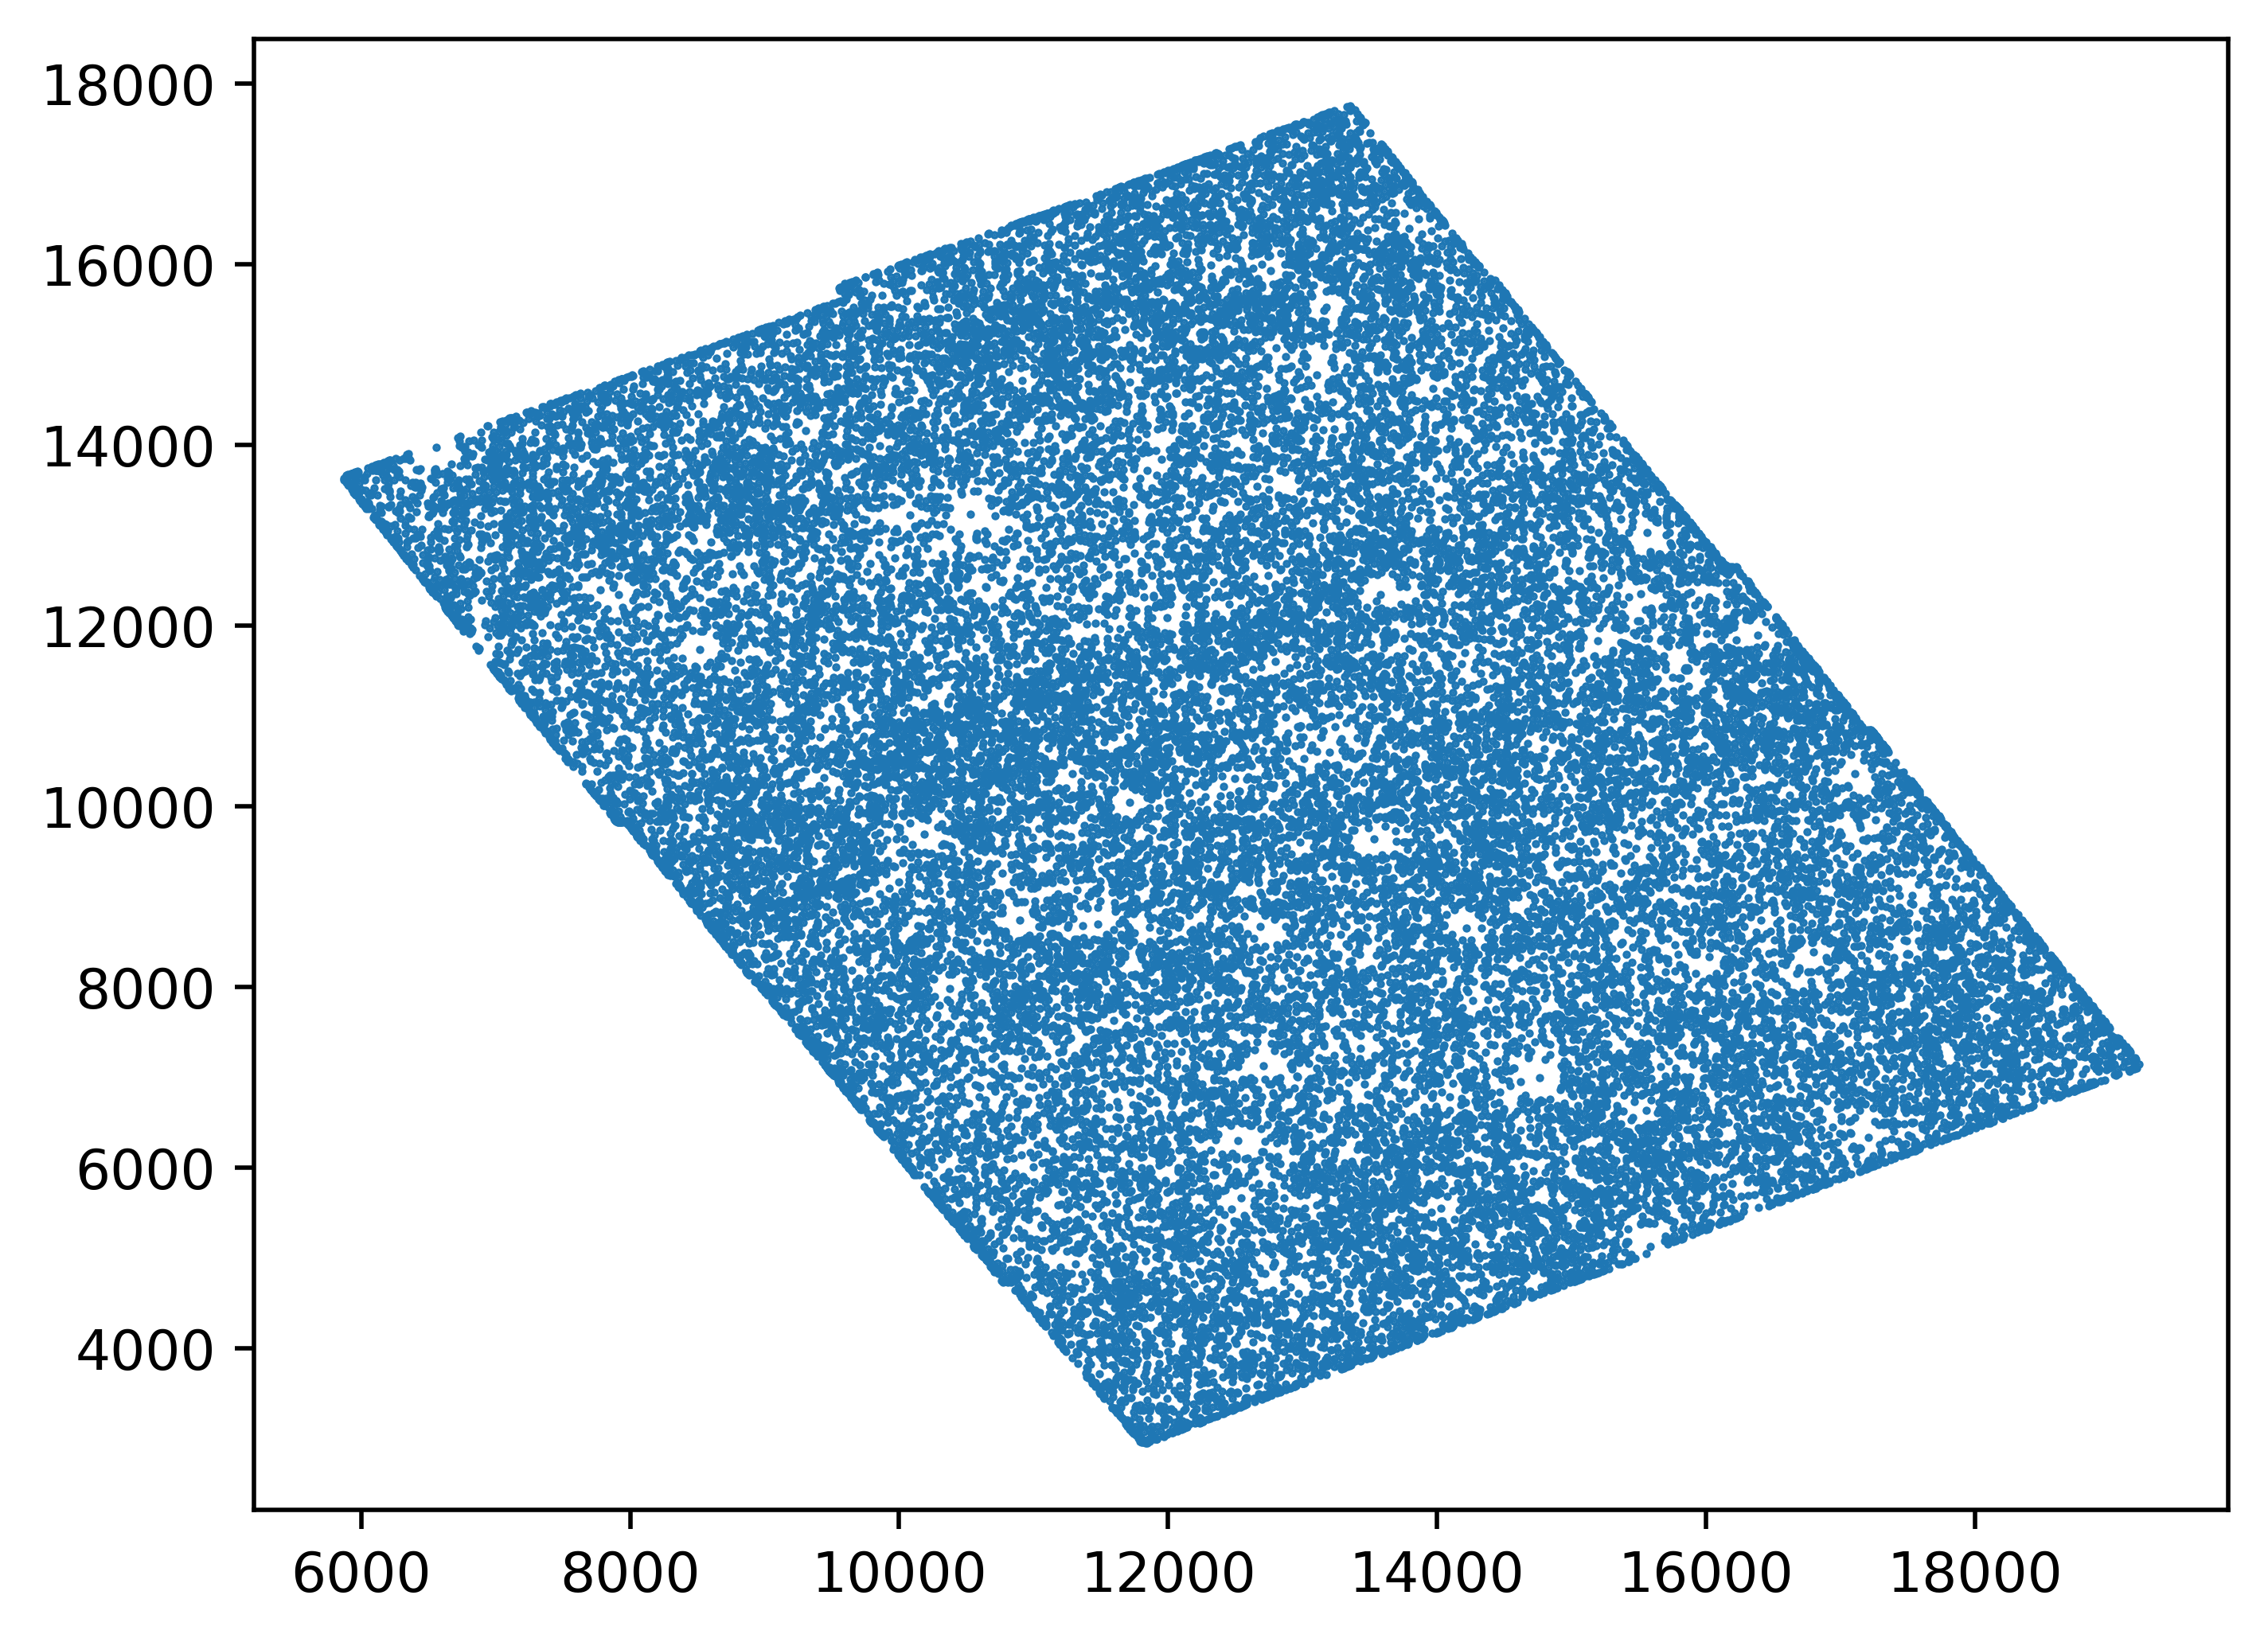

In [4]:
plt.figure(dpi=500)
plt.plot(data['x-position'], data['y-position'], 'o', markersize=0.5)
plt.show()

In [4]:
i = 8
#for i in range(len(d_array)):
params = {
    'dpi': 500,
    #'objxlim': StarLims[:, 0],
    #'objylim': StarLims[:, 1],
    #'xlim':(5500, 19500), 
    #'ylim':(2750, 18000),
    'detThesh': 1,
    #'block': False,
    'vmin': 35,
    'vmax': 97,
    #'cmap': cmaps.oranges_dark,
    #'checkBkg': True
}

ef = ip.ExtractObjectsFlux(jades_files_path[i], bw=256, fw=4, **params)

Exception: internal pixel buffer full: The limit of 300000 active object pixels over the detection threshold was reached. Check that the image is background subtracted and the detection threshold is not too low. If you need to increase the limit, use set_extract_pixstack.

In [ ]:
np.array(data['x-position']), np.array(data['y-position'])

: 

In [ ]:
plt.figure(dpi=10000)
ef.fits_plot_data()
plt.scatter(np.array(data['x-position']), np.array(data['y-position']), s=0.05, marker='.', c='#2BFF0A') 
plt.ylim(2500, 18000)
plt.xlim(5500, 19500)
plt.show()

: 